In [377]:
# Standard imports
import pandas as pd
import numpy as np
import time
import pickle
import math

from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

# Functions (defs) from other notebooks
import ipynb.fs.defs.CreateCollocatedDataFrame as ccdf
import ipynb.fs.defs.machine_learning as ml

# Machine Learning
import h2o
from h2o.automl import H2OAutoML, get_leaderboard
import catboost as cb
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

# Plotting
import matplotlib as mpl
mpl.style.use('classic')
from matplotlib import pyplot as plt
from calendar import month_abbr
from matplotlib.colors import LogNorm

In [2]:
# Set data frame options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
india_df = pd.read_csv('/Users/madsrindal/Desktop/standard_processed_ml_df_india.csv')
iran_df = pd.read_csv('/Users/madsrindal/Desktop/standard_processed_ml_df_iran.csv')
congo_df = pd.read_csv('/Users/madsrindal/Desktop/standard_processed_ml_df_congo.csv')

In [4]:
# INDIA
india_pixel_loc_best = [21.5, 81.5, 21, 82] # Best cell
india_pixel_loc_worst = [20, 83.5, 19.5, 84] # Worst cell
india_df_best = ccdf.filter_location(india_df, india_pixel_loc_best)
india_df_worst = ccdf.filter_location(india_df, india_pixel_loc_worst)

# IRAN
iran_pixel_loc_best = [27.5, 59, 27, 59.5] # Best cell
iran_pixel_loc_worst = [30.5, 59.5, 30, 60] # Worst cell
iran_df_best = ccdf.filter_location(iran_df, iran_pixel_loc_best)
iran_df_worst = ccdf.filter_location(iran_df, iran_pixel_loc_worst)

# CONGO
congo_pixel_loc_best = [-10, 27, -10.5, 27.5] # Best cell
congo_pixel_loc_worst = [-8, 27.5, -8.5, 28] # Worst cell
congo_pixel_loc_forest = [-10, 23.5, -10.5, 24] # Forest cell
congo_df_best = ccdf.filter_location(congo_df, congo_pixel_loc_best)
congo_df_worst = ccdf.filter_location(congo_df, congo_pixel_loc_worst)
congo_df_forest = ccdf.filter_location(congo_df, congo_pixel_loc_forest)

In [5]:
### LUT Made from 0.01x0.01 grid cells ###

# INDIA
dem_df_india_best = pd.read_csv('/Users/madsrindal/Desktop/DEM LUTs/India/LUT_India_BestCorrCell_0.01.csv')
dem_df_india_worst = pd.read_csv('/Users/madsrindal/Desktop/DEM LUTs/India/LUT_India_WorstCorrCell_0.01.csv')

# IRAN
dem_df_iran_best = pd.read_csv('/Users/madsrindal/Desktop/DEM LUTs/Iran/LUT_Iran_BestCorrCell_0.01.csv')
dem_df_iran_worst = pd.read_csv('/Users/madsrindal/Desktop/DEM LUTs/Iran/LUT_Iran_WorstCorrCell_0.01.csv')

# CONGO
dem_df_congo_best = pd.read_csv('/Users/madsrindal/Desktop/DEM LUTs/Congo/LUT_Congo_BestCorrCell_0.01.csv')
dem_df_congo_worst = pd.read_csv('/Users/madsrindal/Desktop/DEM LUTs/Congo/LUT_Congo_WorstCorrCell_0.01.csv')
dem_df_congo_forest = pd.read_csv('/Users/madsrindal/Desktop/DEM LUTs/Congo/LUT_Congo_ForestCorrCell_0.01.csv')

In [6]:
# INDIA
india_df_best = ml.set_dem_parameters(india_df_best, dem_df_india_best)
india_df_worst = ml.set_dem_parameters(india_df_worst, dem_df_india_worst)

100%|██████████| 37099/37099 [00:28<00:00, 1291.34it/s]


In [7]:
# IRAN
iran_df_best = ml.set_dem_parameters(iran_df_best, dem_df_iran_best)
iran_df_worst = ml.set_dem_parameters(iran_df_worst, dem_df_iran_worst)

100%|██████████| 54684/54684 [00:41<00:00, 1304.28it/s]


In [8]:
# CONGO
congo_df_best = ml.set_dem_parameters(congo_df_best, dem_df_congo_best)
congo_df_worst = ml.set_dem_parameters(congo_df_worst, dem_df_congo_worst)
congo_df_forest = ml.set_dem_parameters(congo_df_forest, dem_df_congo_forest)

100%|██████████| 30092/30092 [00:23<00:00, 1289.42it/s]


In [9]:
print(congo_df_best[ congo_df_best['block_code'] == 'UNKNOWN'].shape)
print(congo_df_best.shape)

(1588, 29)
(30086, 29)


In [10]:
def filter_inc_angles(cygnss_df, min_angle, max_angle):
    cygnss_df = cygnss_df[(cygnss_df['sp_inc_angle'] >= min_angle) & (cygnss_df['sp_inc_angle'] <= max_angle)]
    return cygnss_df

In [367]:
# INDIA

best_india_inc_1 = filter_inc_angles(india_df_best, 22, 32)
best_india_inc_2 = filter_inc_angles(india_df_best, 44, 54)
# best_india_inc = best_india_inc.append(filter_inc_angles(india_df_best, 44, 54), ignore_index=True)


worst_india_inc_1 = filter_inc_angles(india_df_worst, 22, 32)
worst_india_inc_2 = filter_inc_angles(india_df_worst, 44, 54)
# worst_india_inc = worst_india_inc.append(filter_inc_angles(india_df_worst, 44, 54), ignore_index=True)

In [216]:
# IRAN
best_iran_inc_1 = filter_inc_angles(iran_df_best, 7, 17)
best_iran_inc_2 = filter_inc_angles(iran_df_best, 28, 38)

worst_iran_inc_1 = filter_inc_angles(iran_df_worst, 7, 17)
worst_iran_inc_2 = filter_inc_angles(iran_df_worst, 28, 38)

In [211]:
# CONGO
best_congo_inc_1 = filter_inc_angles(congo_df_best, 11, 21)
best_congo_inc_2 = filter_inc_angles(congo_df_best, 45, 55)
# best_congo_inc = best_congo_inc.append(filter_inc_angles(congo_df_best, 45, 55), ignore_index=True)

worst_congo_inc_1 = filter_inc_angles(congo_df_worst, 11, 21)
worst_congo_inc_2 = filter_inc_angles(congo_df_worst, 45, 55)
# worst_congo_inc = worst_congo_inc.append(filter_inc_angles(congo_df_worst, 45, 55), ignore_index=True)

forest_congo_inc_1 = filter_inc_angles(congo_df_forest, 11, 21)
forest_congo_inc_2 = filter_inc_angles(congo_df_forest, 45, 55)
#forest_congo_inc = forest_congo_inc.append(filter_inc_angles(congo_df_forest, 45, 55), ignore_index=True)

In [14]:
df_list_optimal = [best_india_inc, worst_india_inc, iran_df_best, iran_df_worst, congo_df_best, congo_df_worst, congo_df_forest]
df_list = [india_df_best, india_df_worst, best_iran_inc, worst_iran_inc, best_congo_inc, worst_congo_inc, forest_congo_inc]
df_names = ['INDIA - BEST CELL', 'INDIA - WORST CELL', 'IRAN - BEST CELL', 'IRAN - WORST CELL', 'CONGO - BEST CELL', 
            'CONGO - WORST CELL', 'CONGO - FOREST CELL']


In [371]:
# INDIA
print('India Best_1: ', best_india_inc_1.shape[0] / india_df_best.shape[0])
print('India Best_2: ', best_india_inc_2.shape[0] / india_df_best.shape[0])
print('India Worst_1: ', worst_india_inc_1.shape[0] / india_df_worst.shape[0])
print('India Worst_2: ', worst_india_inc_2.shape[0] / india_df_worst.shape[0])

# IRAN
print('\nIran Best_1: ', best_iran_inc_1.shape[0] / iran_df_best.shape[0])
print('Iran Best_2: ', best_iran_inc_2.shape[0] / iran_df_best.shape[0])
print('Iran Worst_1: ', worst_iran_inc_1.shape[0] / iran_df_worst.shape[0])
print('Iran Worst_2: ', worst_iran_inc_2.shape[0] / iran_df_worst.shape[0])

# DR CONGO
print('\nCongo Best_1: ', best_congo_inc_1.shape[0] / congo_df_best.shape[0])
print('Congo Best_2: ', best_congo_inc_2.shape[0] / congo_df_best.shape[0])
print('Congo Worst_1: ', worst_congo_inc_1.shape[0] / congo_df_worst.shape[0])
print('Congo Worst_2: ', worst_congo_inc_2.shape[0] / congo_df_worst.shape[0])
print('Congo Forest_1: ', forest_congo_inc_1.shape[0] / congo_df_forest.shape[0])
print('Congo Forest_2: ', forest_congo_inc_2.shape[0] / congo_df_forest.shape[0])

India Best_1:  0.1752919020715631
India Best_2:  0.19113622096672944
India Worst_1:  0.15774010081134263
India Worst_2:  0.2060163346720936

Iran Best_1:  0.08334182789341706
Iran Best_2:  0.20315589896230454
Iran Worst_1:  0.08721015287835564
Iran Worst_2:  0.22715968107673176

Congo Best_1:  0.10749185667752444
Congo Best_2:  0.1991624011167985
Congo Worst_1:  0.09490398818316101
Congo Worst_2:  0.18848913272842371
Congo Forest_1:  0.12614648411537951
Congo Forest_2:  0.1885218662767513


In [169]:
# SET PARAMETER TO PLOT AGAINST SM AND SR

# param = 'delta_angle'
param = 'rmse_distance'

plot_single_year = False
single_year = 2021

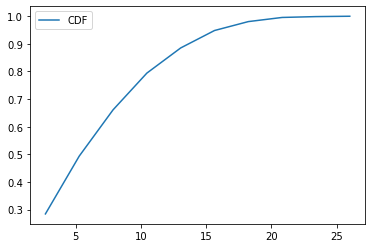

In [167]:
count, bins_count = np.histogram(worst_india_inc['delta_angle'], bins=10)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()
plt.show()

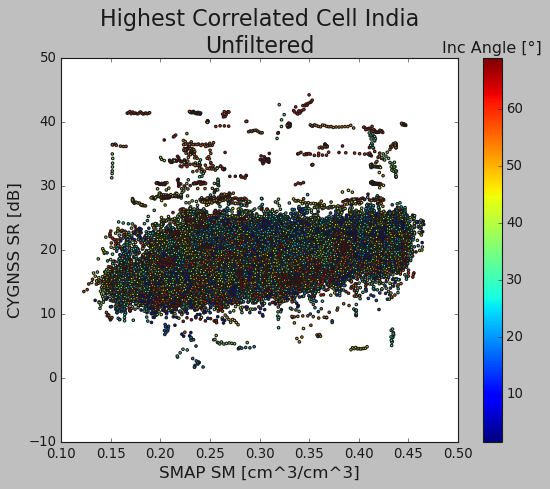

In [372]:
# PLOT ALL VALUES 
df = india_df_best

years_used = '2019-2021'
if plot_single_year:
    df = df[df['year'] == single_year]
    years_used = str(single_year)
plt.scatter(df['smap_sm'], df['sr'], c=df['sp_inc_angle'], cmap='jet', s=5)
bar = plt.colorbar()
bar.ax.set_title('Inc Angle [°]')
#plt.title('Highest Corr Cell India' + ' - ' + years_used)
plt.title('Highest Correlated Cell India\nUnfiltered', fontsize=20)
plt.xlabel('SMAP SM [cm^3/cm^3]', fontsize=15)
plt.ylabel('CYGNSS SR [dB]', fontsize=15)
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/CYGNSS_data_India_unfiltered.png')
plt.show()

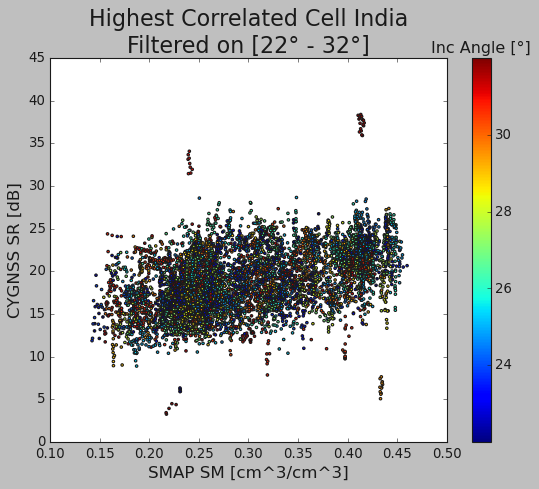

In [374]:
# PLOT FILTERED VALUES 
df = best_india_inc_1

years_used = '2019-2021'
if plot_single_year:
    df = df[df['year'] == single_year]
    years_used = str(single_year)
plt.scatter(df['smap_sm'], df['sr'], c=df['sp_inc_angle'], cmap='jet', s=5)
bar = plt.colorbar()
bar.ax.set_title('Inc Angle [°]')
#plt.title('Highest Corr Cell India' + ' - ' + years_used)
plt.title('Highest Correlated Cell India\nFiltered on [22° - 32°]', fontsize=20)
plt.xlabel('SMAP SM [cm^3/cm^3]', fontsize=15)
plt.ylabel('CYGNSS SR [dB]', fontsize=15)
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/CYGNSS_data_India_filtered[22-32].png')
plt.show()

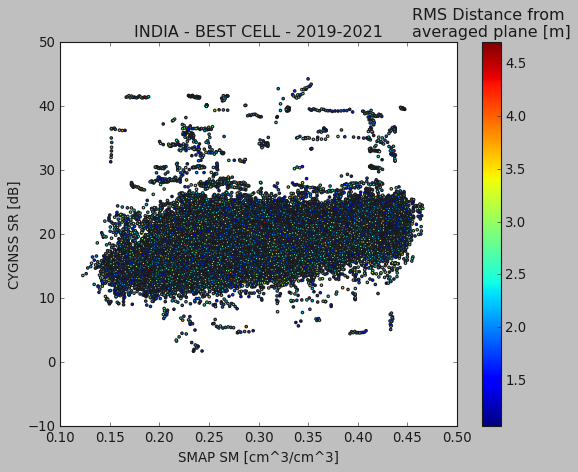

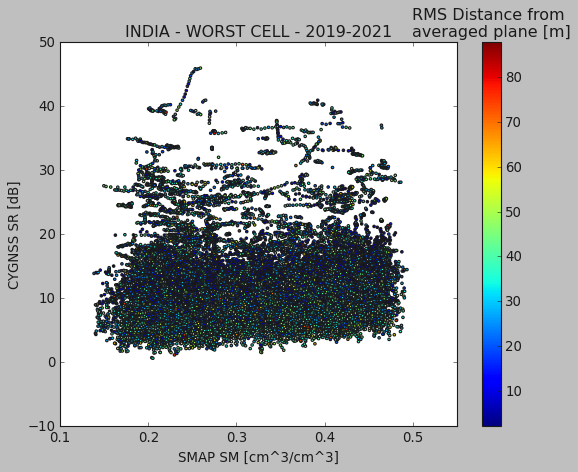

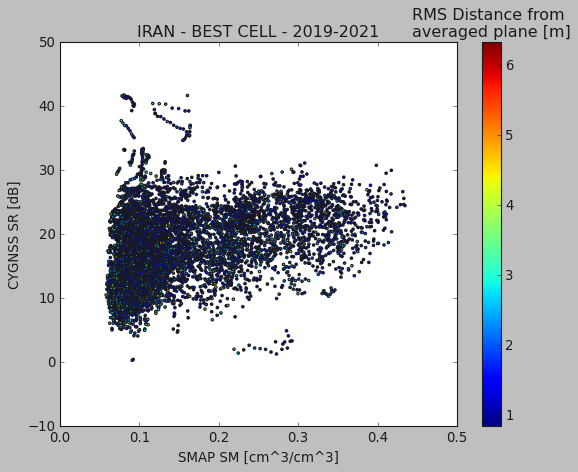

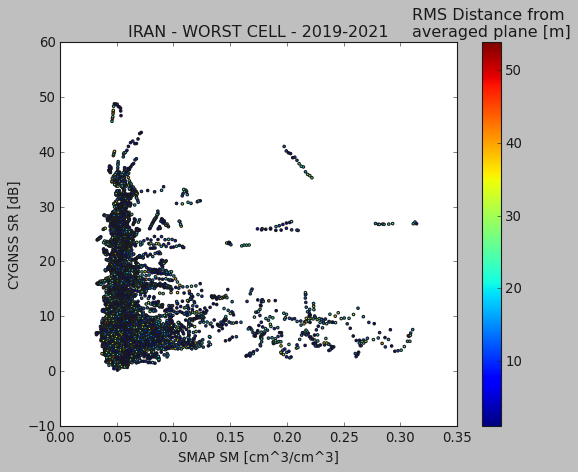

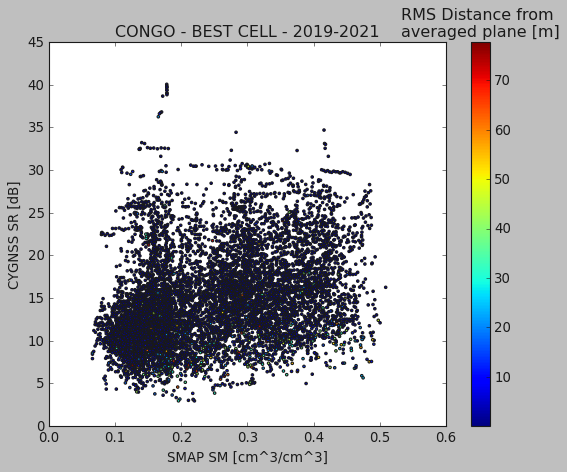

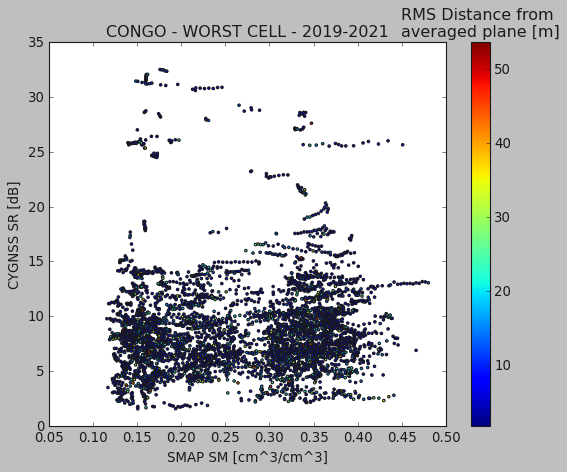

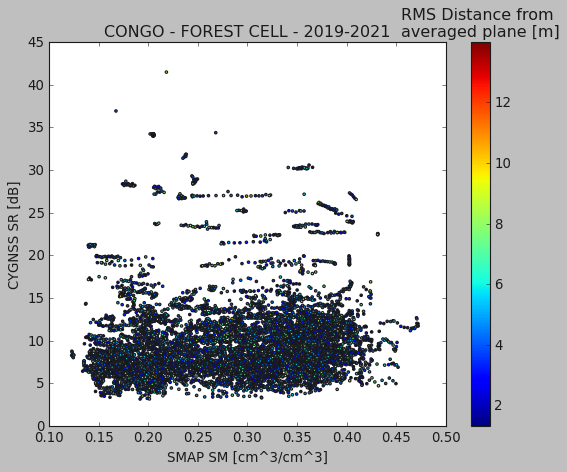

In [378]:
counter = 0
if param == 'delta_angle':
    bar_title = 'Δφ [°]'
elif param == 'rmse_distance':
    bar_title = 'RMS Distance from \naveraged plane [m]'
else:
    bar_title = param

for df in df_list:
    years_used = '2019-2021'
    if plot_single_year:
        df = df[df['year'] == single_year]
        years_used = str(single_year)
    plt.scatter(df['smap_sm'], df['sr'], c=df[param], cmap='jet', s=5)
    bar = plt.colorbar()
    bar.ax.set_title(bar_title)
    plt.title(df_names[counter] + ' - ' + years_used)
    plt.xlabel('SMAP SM [cm^3/cm^3]')
    plt.ylabel('CYGNSS SR [dB]')
    plt.show()
    counter += 1

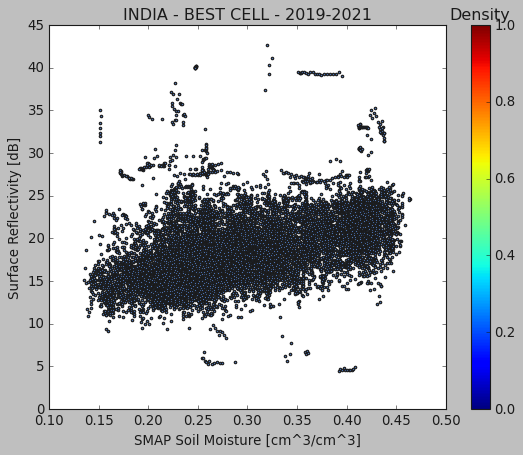

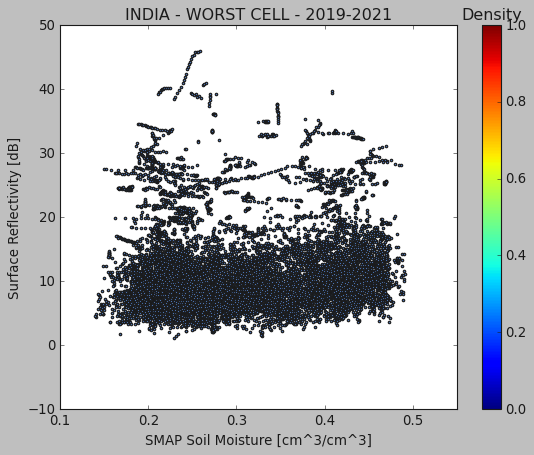

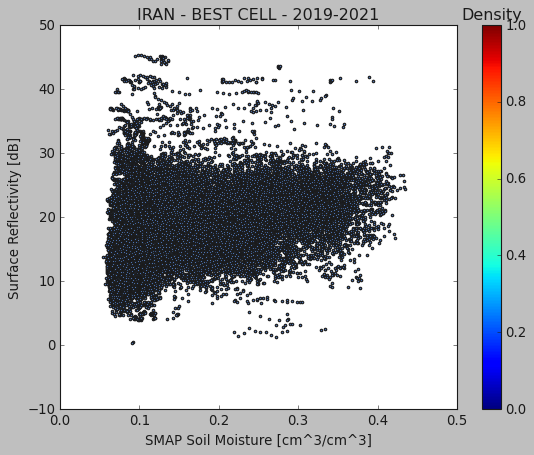

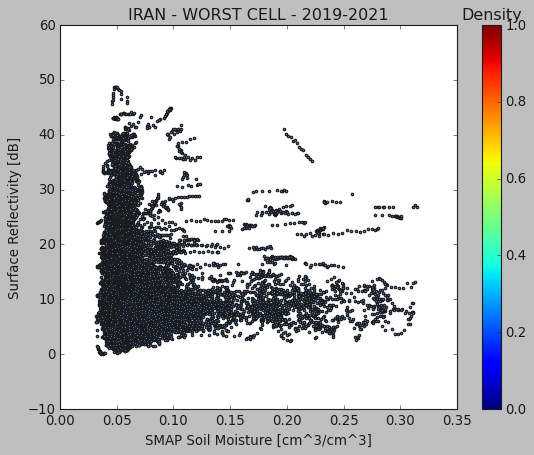

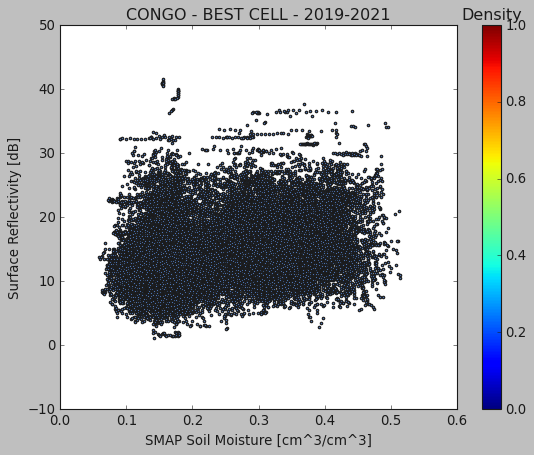

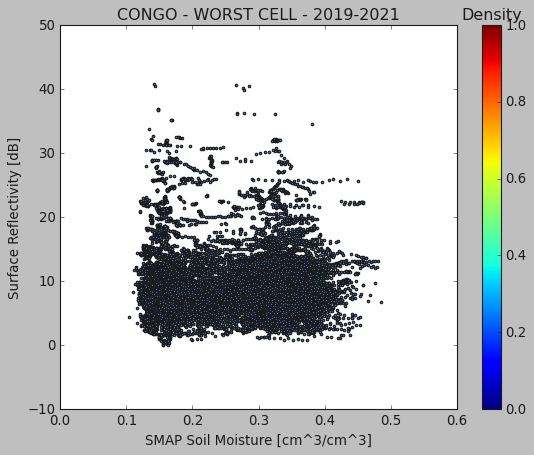

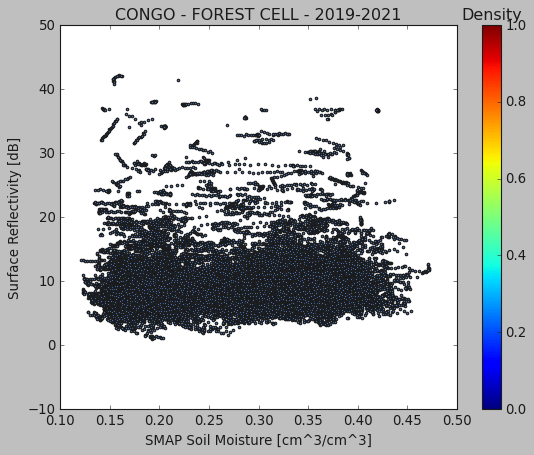

In [379]:
from matplotlib.colors import LogNorm

counter = 0
if param == 'delta_angle':
    bar_title = 'Δφ [°]'
elif param == 'rmse_distance':
    bar_title = 'RMS Distance from \naveraged plane [m]'
else:
    bar_title = param

for df in df_list_optimal:
    years_used = '2019-2021'
    if plot_single_year:
        df = df[df['year'] == single_year]
        years_used = str(single_year)
    
    # hist = plt.hist2d(df['smap_sm'], df['sr'], (20, 20), cmap=plt.cm.jet, norm=LogNorm(), cmin=1)
    plt.scatter(df['smap_sm'], df['sr'], cmap='jet', s=5)
    bar = plt.colorbar()
    bar.ax.set_title('Density')
    plt.title(df_names[counter] + ' - ' + years_used)
    plt.ylabel('Surface Reflectivity [dB]', fontsize=12)
    plt.xlabel('SMAP Soil Moisture [cm^3/cm^3]', fontsize=12)
    plt.show()
    counter += 1

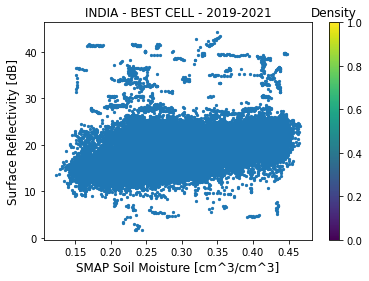

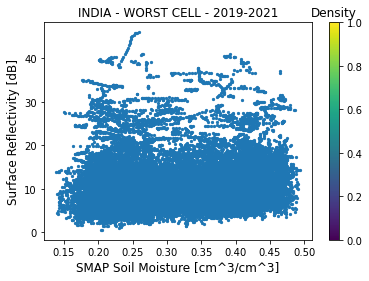

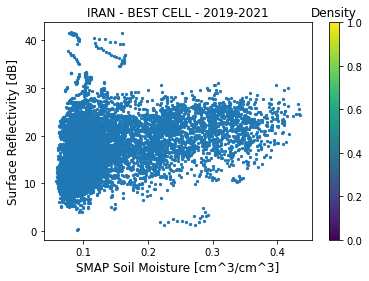

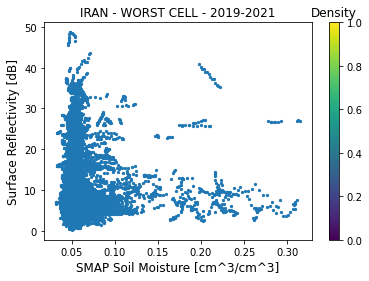

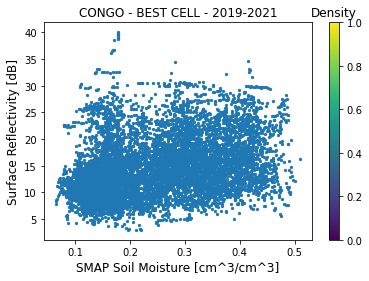

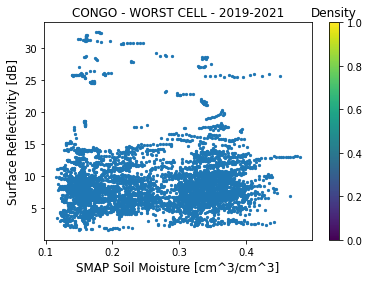

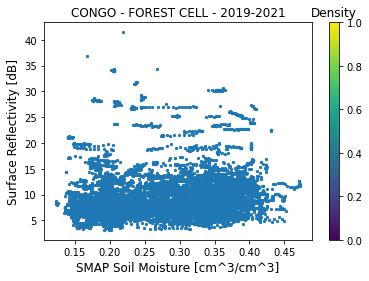

In [188]:
counter = 0
if param == 'delta_angle':
    bar_title = 'Δφ [°]'
elif param == 'rmse_distance':
    bar_title = 'RMS Distance from \naveraged plane [m]'
else:
    bar_title = param

for df in df_list:
    years_used = '2019-2021'
    if plot_single_year:
        df = df[df['year'] == single_year]
        years_used = str(single_year)
    
    # hist = plt.hist2d(df['smap_sm'], df['sr'], (20, 20), cmap=plt.cm.jet, norm=LogNorm(), cmin=1)
    plt.scatter(df['smap_sm'], df['sr'], cmap='jet', s=5)
    bar = plt.colorbar()
    bar.ax.set_title('Density')
    plt.title(df_names[counter] + ' - ' + years_used)
    plt.ylabel('Surface Reflectivity [dB]', fontsize=12)
    plt.xlabel('SMAP Soil Moisture [cm^3/cm^3]', fontsize=12)
    plt.show()
    counter += 1

In [113]:
df = india_df_worst

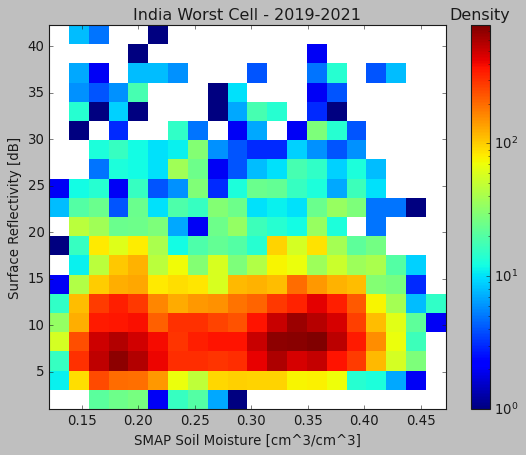

In [380]:
years_used = '2019-2021'
if plot_single_year:
    df = df[df['year'] == single_year]
    years_used = str(single_year)

hist = plt.hist2d(df['smap_sm'], df['sr'], (20, 20), cmap=plt.cm.jet, norm=LogNorm(), cmin=1)
bar = plt.colorbar()
bar.ax.set_title('Density')
plt.title('India Worst Cell - ' + years_used)
plt.ylabel('Surface Reflectivity [dB]', fontsize=12)
plt.xlabel('SMAP Soil Moisture [cm^3/cm^3]', fontsize=12)
plt.show()

In [ ]:
years_used = '2019-2021'
if plot_single_year:
    df = df[df['year'] == single_year]
    years_used = str(single_year)

hist = plt.hist2d(df['smap_sm'], df['sr'], (20, 20), cmap=plt.cm.jet, norm=LogNorm(), cmin=1)
bar = plt.colorbar()
bar.ax.set_title('Density')
plt.title('India Worst Cell - ' + years_used)
plt.ylabel('Surface Reflectivity [dB]', fontsize=12)
plt.xlabel('SMAP Soil Moisture [cm^3/cm^3]', fontsize=12)
plt.show()

In [ ]:
### AUTO ML TESTING ###

In [194]:
try:
    h2o.shutdown()
except:
    pass

/Users/madsrindal/opt/miniconda3/envs/SemesterProject/lib/python3.7/site-packages/ipykernel_launcher.py:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  


In [195]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "15" 2020-09-15; OpenJDK Runtime Environment (build 15+36-1562); OpenJDK 64-Bit Server VM (build 15+36-1562, mixed mode, sharing)
  Starting server from /Users/madsrindal/opt/miniconda3/envs/SemesterProject/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gn/4ykvjj5x03v48y9sy_v11zlh0000gn/T/tmp_jtn3w4z
  JVM stdout: /var/folders/gn/4ykvjj5x03v48y9sy_v11zlh0000gn/T/tmp_jtn3w4z/h2o_madsrindal_started_from_python.out
  JVM stderr: /var/folders/gn/4ykvjj5x03v48y9sy_v11zlh0000gn/T/tmp_jtn3w4z/h2o_madsrindal_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,1 month and 26 days
H2O_cluster_name:,H2O_from_python_madsrindal_oi4flg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [196]:
# Create train/test split in dataset.
# The value on format [day, month, year] indicates test data from provided date 
data_split_date = [1, 7, 2021]

In [197]:
# ml_df = india_df_best.copy()
ml_df = congo_df_best.copy()
print('The shape of the pixel data frame: ', ml_df.shape)

all_features = ['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle', 'smap_vo', 'smap_surface_roughness', 'block_code', 'time_of_day', 'delta_angle', 'rmse_distance']
cat_features = ['day_of_year', 'block_code', 'time_of_day']

ml_features = all_features[:-2]
print(ml_features)

ml_df_train, ml_df_test = ml.split_df_by_date(ml_df, data_split_date[0], data_split_date[1], data_split_date[2])
ml_df_train = ccdf.select_df_features(ml_df_train, ml_features)
ml_df_test = ccdf.select_df_features(ml_df_test, ml_features)
print('The shape of the training data: ', ml_df_train.shape)
print('The shape of the testing data: ', ml_df_test.shape)


The shape of the pixel data frame:  (30086, 29)
['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle', 'smap_vo', 'smap_surface_roughness', 'block_code', 'time_of_day']
The shape of the training data:  (24457, 8)
The shape of the testing data:  (5629, 8)


In [198]:
train_h2o = h2o.H2OFrame(ml_df_train)
test_h2o = h2o.H2OFrame(ml_df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [199]:
y = 'smap_sm'
x = train_h2o.columns
x.remove(y)

train_h2o['day_of_year'] = train_h2o['day_of_year'].asfactor()
train_h2o['block_code'] = train_h2o['block_code'].asfactor()
train_h2o['time_of_day'] = train_h2o['time_of_day'].asfactor()

test_h2o['day_of_year'] = test_h2o['day_of_year'].asfactor()
test_h2o['block_code'] = test_h2o['block_code'].asfactor()
test_h2o['time_of_day'] = test_h2o['time_of_day'].asfactor()

In [200]:
xgb_model = h2o.upload_model("/Users/madsrindal/Desktop/AutoML - Models/Congo/BestCell/2features/XGBoost_grid_1_AutoML_1_20220606_113546_model_1")
# dl_model = h2o.upload_model("/Users/madsrindal/Desktop/AutoML - Models/Iran/WorstCell/2features/DeepLearning_grid_1_AutoML_1_20220606_105109_model_1")


In [201]:
print(xgb_model.varimp(use_pandas=True))
# print(dl_model.varimp(use_pandas=True))

  variable  relative_importance  scaled_importance  percentage
0       sr            39.290977                1.0         1.0


In [202]:
xgb_preds = xgb_model.predict(test_h2o)
# dl_preds = dl_model.predict(test_h2o)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [203]:
xgb_predictions = h2o.as_list(xgb_preds)
# dl_predictions = h2o.as_list(dl_preds)

In [204]:
rmse_xgboost = mean_squared_error(h2o.as_list(test_h2o['smap_sm'])['smap_sm'], xgb_predictions['predict'], squared=False)
print('RMSE XGBOOST: ', rmse_xgboost)

#rmse_dl = mean_squared_error(h2o.as_list(test_h2o['smap_sm'])['smap_sm'], dl_predictions['predict'], squared=False)
#print('RMSE DEEP LEARNING: ', rmse_dl)


RMSE XGBOOST:  0.0959304160954184


In [205]:
smap_sm_list = list(h2o.as_list(test_h2o['smap_sm'])['smap_sm'])
xgb_predicted_sm_list = list(xgb_predictions['predict'])
#dl_predicted_sm_list = list(dl_predictions['predict'])

In [206]:
train, test = ml.split_df_by_date(ml_df, data_split_date[0], data_split_date[1], data_split_date[2])

In [207]:
test = ccdf.select_df_features(test, ['sr', 'smap_sm', 'day_of_year'])

In [208]:
sm_dict = {
    'smap_sm': smap_sm_list,
    'predicted_sm_XGBoost': xgb_predicted_sm_list,
    'day_of_year': list(test['day_of_year'])
}

In [209]:
sm_df = pd.DataFrame(sm_dict)

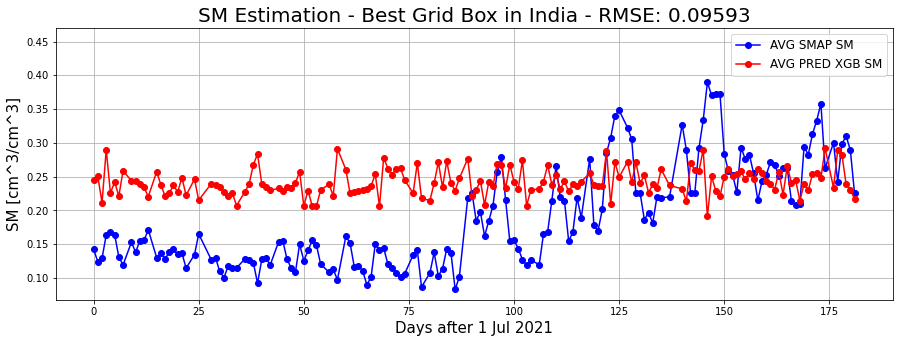

In [210]:
start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        #avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        #avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, color='red', marker="o", label='AVG PRED XGB SM')
# ax.plot(days, avg_pred_sm_values_dl, color='orange', marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=15)
ax.set_ylim(top=0.47)
ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=15)
plt.legend(fontsize='large')
plt.title('SM Estimation - Best Grid Box in India - RMSE: ' + str(round(rmse_xgboost, 5)), fontsize=20)
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/PredictedTS_8params_India.png', format='png')
plt.show()


In [ ]:
## DIV ##

In [159]:
# GBM Model
test_model_india = h2o.upload_model("/Users/madsrindal/Desktop/AutoML - Models/India/BestCell/['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle', 'smap_vo', 'smap_surface_roughness', 'block_code', 'time_of_day']/GBM_1_AutoML_1_20220520_132736")
test_model_india.varimp(use_pandas=True)
# test_model_india.varimp_plot()


,variable,relative_importance,scaled_importance,percentage
0,day_of_year,659.713867,1.000000,0.777954
1,sr,73.070847,0.110761,0.086167
2,smap_vo,32.009331,0.048520,0.037746
3,smap_surface_roughness,27.025021,0.040965,0.031869
4,sp_inc_angle,24.606525,0.037299,0.029017
5,time_of_day,17.965319,0.027232,0.021185
6,block_code,13.620452,0.020646,0.016062


In [230]:
test_model_india = h2o.upload_model("/Users/madsrindal/Desktop/AutoML - Models/India/BestCell/['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle', 'smap_vo', 'smap_surface_roughness', 'block_code', 'time_of_day']/XGBoost_3_AutoML_1_20220520_132736")
test_model_india.varimp(use_pandas=True).head(7)


,variable,relative_importance,scaled_importance,percentage
0,sr,75.156258,1.000000,0.260999
1,smap_surface_roughness,17.651567,0.234865,0.061299
2,smap_vo,17.113298,0.227703,0.059430
3,sp_inc_angle,7.914740,0.105310,0.027486
4,day_of_year.208,3.111732,0.041403,0.010806
5,day_of_year.234,2.983412,0.039696,0.010361
6,day_of_year.224,2.964173,0.039440,0.010294


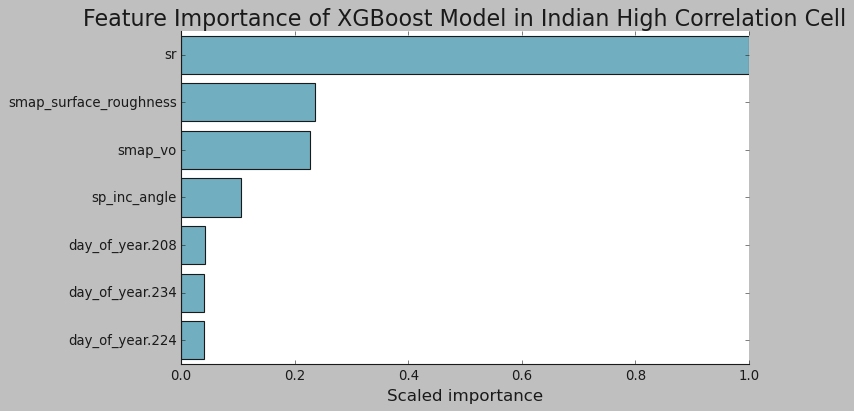

In [322]:
test_model_india = h2o.upload_model("/Users/madsrindal/Desktop/AutoML - Models/India/BestCell/['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle', 'smap_vo', 'smap_surface_roughness', 'block_code', 'time_of_day']/XGBoost_3_AutoML_1_20220520_132736")
varimp_df = test_model_india.varimp(use_pandas=True).head(7)

ax = sns.catplot(x="scaled_importance", y="variable", data=varimp_df, color="c", kind="bar", orient="h", height=5, aspect=2)
ax.set(ylabel=None)
plt.title('Feature Importance of XGBoost Model in Indian High Correlation Cell', fontsize=20)
plt.xlabel('Scaled importance', fontsize=15)
plt.savefig('/Users/madsrindal/Desktop/Master Plots/XGBoost_varimp_8features_India_best', bbox_inches='tight')
plt.show()


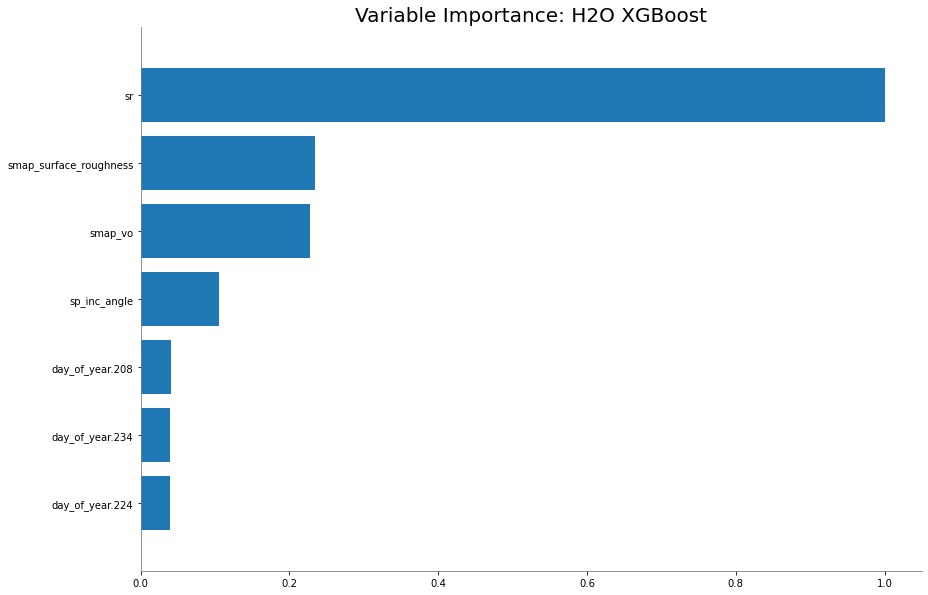

<Figure size 432x288 with 0 Axes>

In [227]:
# XGBoost Model - Best India
test_model_india = h2o.upload_model("/Users/madsrindal/Desktop/AutoML - Models/India/BestCell/['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle', 'smap_vo', 'smap_surface_roughness', 'block_code', 'time_of_day']/XGBoost_3_AutoML_1_20220520_132736")
#test_model_india.varimp(use_pandas=True)
test_model_india.varimp_plot(7)
plt.savefig('/Users/madsrindal/Desktop/Master Plots/XGBoost_8params_varimp.png', bbox_inches='tight')
plt.show()


<IPython.core.display.Javascript object>


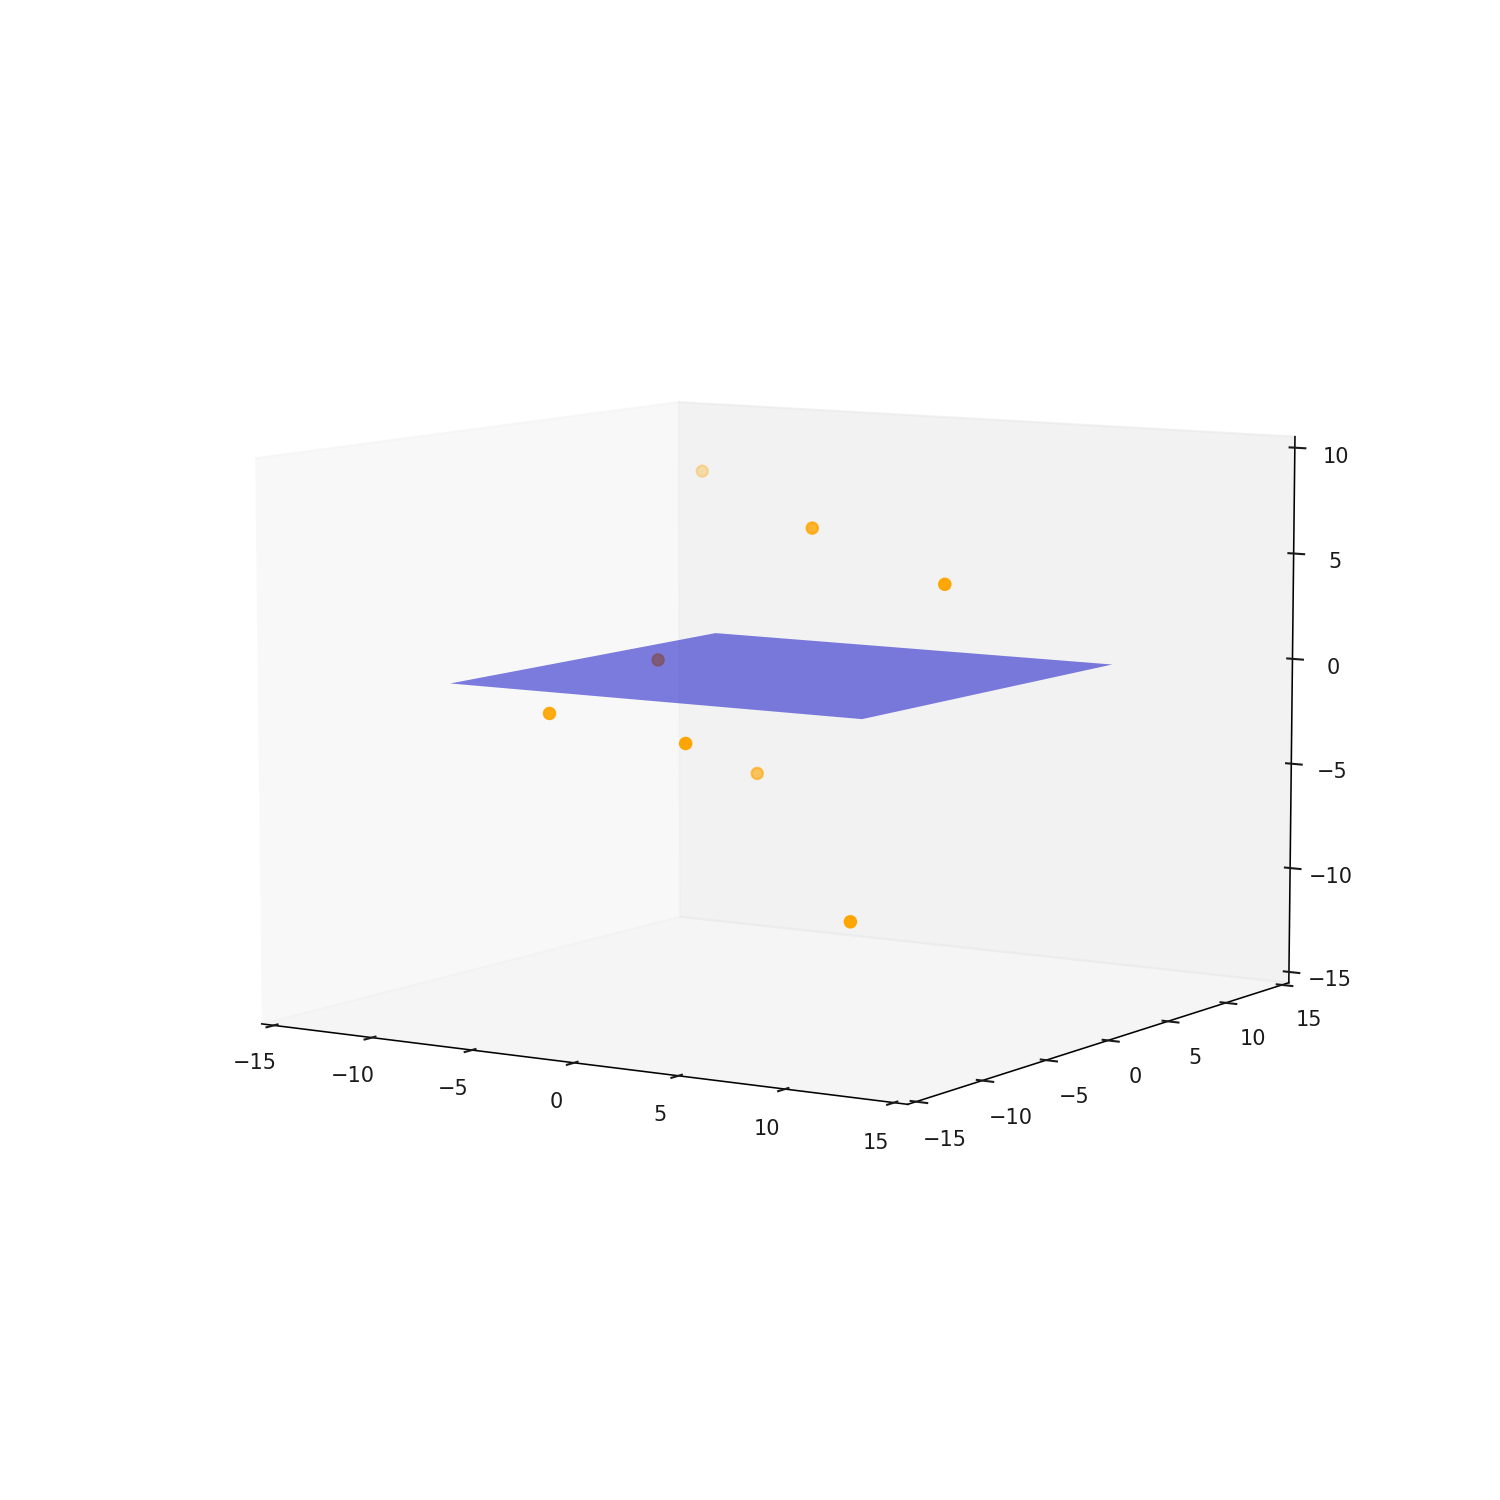

In [533]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import random 


fig = plt.figure(figsize = (5, 5))
#ax = Axes3D(fig)
ax = plt.axes(projection='3d')

dim = 10

# Define x,y plane.
X, Y = np.meshgrid([-dim, dim], [-dim, dim])
Z = np.zeros((2, 2))

# Define inclined plane.
angle = 0.25  # <-- This is the variable
X2, Y2 = np.meshgrid([-dim, dim], [0, dim])
Z2 = Y2 * angle
X3, Y3 = np.meshgrid([-dim, dim], [-dim, 0])
Z3 = Y3 * angle

# Plot x,y plane.
ax.plot_surface(X, Y, Z, color='blue', alpha=.5, linewidth=0, zorder=1)

# Plot points
"""num_of_points = 8
x_vals = list(range(-10, 10))
y_vals = list(range(-10, 10))
z_vals = list(range(-10, 10))

random.shuffle(x_vals)
random.shuffle(y_vals)
random.shuffle(z_vals)
ax.scatter(x_vals[:num_of_points], y_vals[:num_of_points], z_vals[:num_of_points], s=30, marker='o', color='orange')"""
ax.scatter(x, y, z, s=30, marker='o', color='orange')
ax.grid(False)


# Plot top half of inclined plane.
#ax.plot_surface(X2, Y2, Z2, color='blue', alpha=.5, linewidth=0, zorder=3)

# Plot bottom half of inclined plane.
#ax.plot_surface(X2, Y3, Z3, color='blue', alpha=.5, linewidth=0, zorder=-1)



# plt.savefig('/Users/madsrindal/Desktop/Master Plots/3D test')

plt.show()


In [523]:
x = x_vals[:num_of_points]
y = y_vals[:num_of_points]
z = z_vals[:num_of_points]